In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from lifelines import WeibullFitter
import matplotlib.pyplot as plt

Based off of: https://www.mathworks.com/help/predmaint/ref/reliabilitysurvivalmodel.html

Using lifelines WeibullFitter from: https://lifelines.readthedocs.io/en/latest/fitters/univariate/WeibullFitter.html

reliabilityData is a vector of time to failure. Because it is a .mat object I first turned it into ints of seconds, then saved that so it is easier to work with.

My understanding of the documentation example is that it fits their reliability survival model to a weibull distribution (that is the default, there are other options).

In [2]:
from scipy.io import loadmat

# load in data, turn it into 1d array
mat_data = loadmat('/Users/nechamab/Downloads/durations_seconds.mat')
durations = mat_data['durationsInSeconds'].flatten()
print(durations[:10])


[252545.53058122 278997.8107494  242587.3947855  265654.56485491
 236067.37723076 256324.91311954 230289.57747618 269337.47716175
 233873.8222324  220853.10296311]


In [3]:
# array of 1s because nothing is censored right now
event_observed = np.ones_like(durations) 
duration_hours = durations / 3600

In [4]:
# fit a weibull distribution
weibull = WeibullFitter()
weibull.fit(duration_hours, event_observed)

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1000 total observations, 0 right-censored observations>

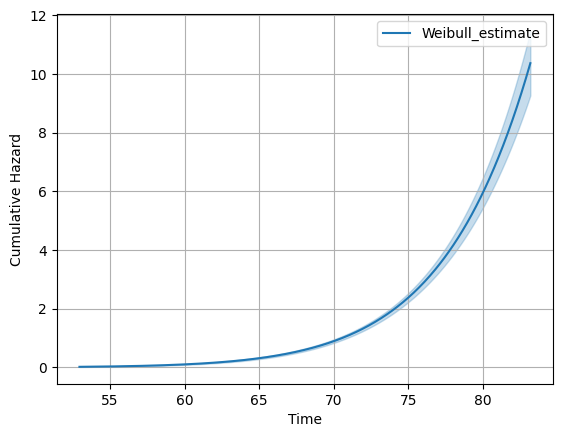

In [5]:
# this plots the cumulative hazard function
weibull.plot()
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.grid(True)
plt.show()

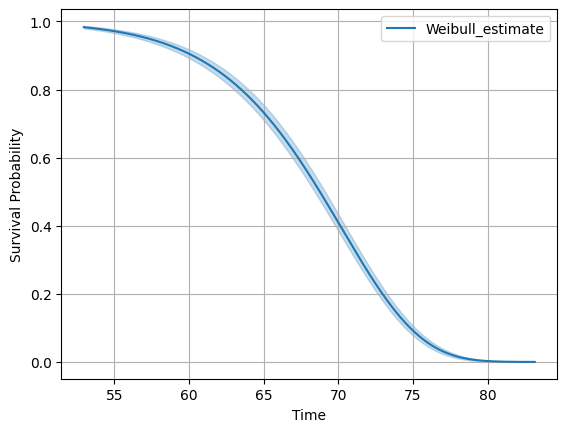

In [6]:
# this plots the survival function
weibull.plot_survival_function()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

In [7]:
# Print model parameters
# Weibull shape parameter. Controls if cumulative hazard is convex or concave
print("ρ:", weibull.rho_)
# Weibull scale parameter , controls
print("λ:", weibull.lambda_)

ρ: 14.236532483982558
λ: 70.5645165473171


Now we predict the life span of a new component, and obtain the probability distribution function for the estimate.

Mathworks writes this: [estRUL, ciRUL, pdfRUL] = predictRUL(mdl);
It seems to return expected Remaining Useful Life, confidence interval for RUL, and full RUL.
Here we are computing the full RUL


In [8]:
def predict_rul_pdf(model, current_age=0, bin_size=1.0, num_bins=100):
    # compute the remaining usefull life probabilty distribution function over a ragne of times
    max_rul = bin_size * num_bins
    rul_times = np.linspace(0, max_rul, num_bins)
    absolute_times = current_age + rul_times

    # convert survival at current time to float (bec it was not working before as it was a Pandas series)
    S_current = float(model.survival_function_at_times(current_age).values[0])

    # finding the conditional survival function - probability the system lasts r more hours, given it survived up to time t
    # S(t+r)/S(t)
    S_future = model.survival_function_at_times(absolute_times).values.flatten()
    conditional_survival = S_future / S_current
    
    # probability distribution is neg derivative of survival funtion
    # had to google how to do this part, want to confirm
    pdf_vals = -np.gradient(conditional_survival, bin_size)
    pdf_vals = np.maximum(pdf_vals, 0)
    pdf_vals /= np.sum(pdf_vals) * bin_size

    return rul_times, pdf_vals # remaining useful life times and the corresponding probability distribution function values


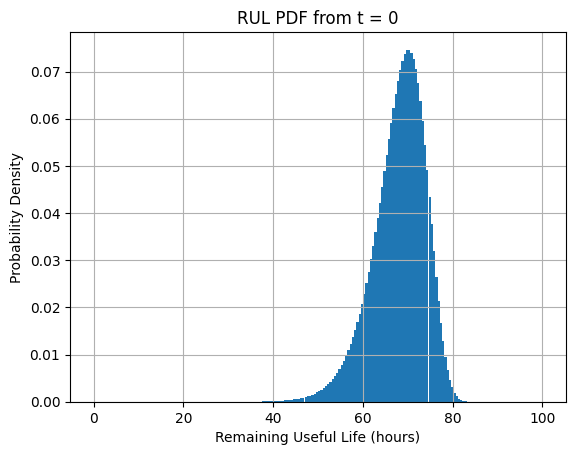

In [9]:
rul_bins, rul_pdf = predict_rul_pdf(weibull, current_age=0, bin_size=0.5, num_bins=200)

plt.bar(rul_bins, rul_pdf, width=0.5)
plt.xlabel("Remaining Useful Life (hours)")
plt.ylabel("Probability Density")
plt.title("RUL PDF from t = 0")
plt.grid(True)
plt.show()

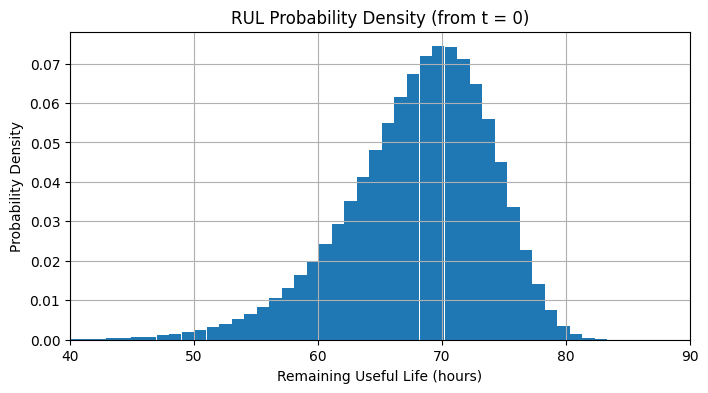

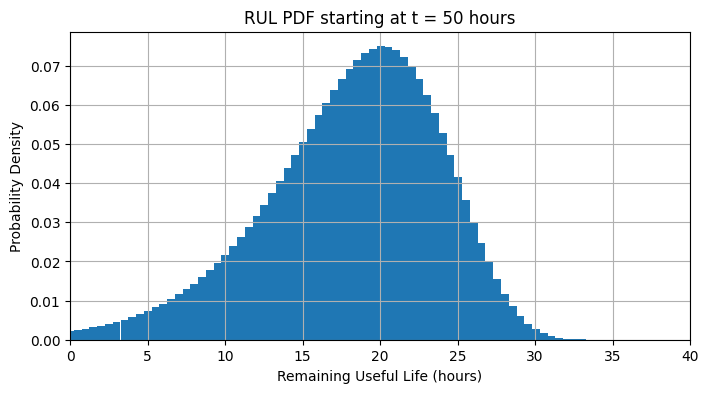

In [10]:
rul_bins, rul_pdf = predict_rul_pdf(weibull, current_age=0, bin_size=1.0, num_bins=100)

plt.figure(figsize=(8, 4))
plt.bar(rul_bins, rul_pdf, width=1.0)
plt.title("RUL Probability Density (from t = 0)")
plt.xlabel("Remaining Useful Life (hours)")
plt.ylabel("Probability Density")
plt.xlim(40, 90)
plt.grid(True)
plt.show()

# -----------------------------
# Predict RUL from t = 50 hours
# -----------------------------
rul_bins2, rul_pdf2 = predict_rul_pdf(weibull, current_age=50, bin_size=0.5, num_bins=500)

plt.figure(figsize=(8, 4))
plt.bar(rul_bins2, rul_pdf2, width=0.5)
plt.title("RUL PDF starting at t = 50 hours")
plt.xlabel("Remaining Useful Life (hours)")
plt.ylabel("Probability Density")
plt.xlim(0, 40)
plt.grid(True)
plt.show()

The graph is saying how likely it is for the product to last untill that many more hours. So the peak is how long it thinks it will last before it fails, and then the probability of it lasting shorter or longer is lower

In [ ]:
# expected RUL which is just the mean
expect_rul = np.sum(rul_bins * rul_pdf)
print(f"Expected RUL: {expect_rul:.2f} hours")


Expected RUL: 68.03 hours


In [ ]:
# confidence RUL- 95% confidence that product will fail btw the two outputted times
# get cumulative distribution function
cdf = np.cumsum(rul_pdf)
#print(cdf[-1])

# find indicies closest to 2.5% and 97.5% to get the middle 95% of the distribution
low_idx = np.searchsorted(cdf, 0.025)
high_idx = np.searchsorted(cdf, 0.975)

# map the indices back to RUL values
ci_low = rul_bins[low_idx]
ci_high = rul_bins[high_idx]

print(f"95% confidence interval: {ci_low:.2f}, {ci_high:.2f}")


95% confidence interval: 54.55, 77.78
